In this notebook, we empirically compute the "kernel stochastic integral". We use two kernels: the Gaussian kernel which is $C^{\infty}$ and the Brownian motion kernel which is piecewise linear. By existing theory, we know that using linear interpolation splines, the integral converges to the Stratonovich integral. This results is confirmed in our numerical experiements. 

On the other hand, the Gaussian kernel does not converge to either the Ito definition or the Stratonovich definition. In fact it appears to diverge was the resolution goes to 0. However this is also coupled with an increase in the interpolation error, suggesting perhaps numerical issues.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import scipy
from scipy import linalg
from tqdm import tqdm

In [2]:
def compute_pairwise_norm(x,y):
    
    diff = (x[:, None, :] - y[None, :, :])
    
    norm  = np.linalg.norm(diff, axis = -1)
    
    return norm

def gaussian_kernel(matrix_1, matrix_2, l):
    
    diff = compute_pairwise_norm(matrix_1,matrix_2)
    
    return np.exp(-diff**2/(2*l**2))



In [3]:
# Generate brownian motion
def generate_bm(delta_t, T, n_samples, seed = 0):
    N = int(T/delta_t)
    bm = []
    x = 0
    time = np.linspace(0, T, N)
    #print(time)
    np.random.seed(seed)
    rv = np.random.normal(size = (n_samples, N))

    rv.shape

    bm = np.cumsum(rv*np.sqrt(delta_t), axis = -1)
    
    return bm

In [4]:
brownian_motion_kernel(0, 1, 0.1, 0.1)

NameError: name 'brownian_motion_kernel' is not defined

In [ ]:
t0, t1 = 0.01, 1.0
dt= 0.001
time_span = np.arange(t0,t1,dt)

f = np.cos(time_span*4*np.pi)

dt_obs = 0.05

time_span_obs = np.arange(t0,t1,dt_obs)
y = np.cos(np.arange(t0,t1,dt_obs)*4*np.pi)

In [ ]:
plt.plot(time_span, f)
plt.scatter(np.arange(t0,t1,dt_obs), y)

In [ ]:
np.arange(t0,t1,dt_obs)

In [5]:
K_bm = brownian_motion_kernel(t0, t1,dt_obs, dt_obs)
I = np.eye(K_bm.shape[0])
nugget = 1e-10
c = linalg.solve(K_bm + nugget*I, y, assume_a='pos')

pred_interp = K_bm@c

K_bm_test = brownian_motion_kernel(t0, t1,dt, dt_obs)
pred = K_bm_test@c

NameError: name 'brownian_motion_kernel' is not defined

In [6]:
plt.plot(time_span, f)
plt.scatter(np.arange(t0,t1,dt_obs), y)

plt.scatter(np.arange(t0,t1,dt_obs), pred_interp, c = 'red')
plt.plot(np.arange(t0,t1,dt), pred, c = 'green')

NameError: name 'time_span' is not defined

In [7]:
# Generating a Brownian motion

In [8]:
delta_t = 0.01

T = 1.0

N = int(T/delta_t)

bm = []
x = 0
time = np.linspace(0, T, N)
for i in range(N):
    bm.append(x)
    x += np.sqrt(delta_t)*np.random.normal()
    
bm = np.array(bm)

In [9]:
n_samples = 101

delta_t = 0.01

T = 1.0

N = int(T/delta_t)

bm = []
x = 0
time = np.linspace(0, T, N)

rv = np.random.normal(size = (n_samples, N))

rv.shape

bm = np.cumsum(rv*np.sqrt(delta_t), axis = -1)

bm.shape

(101, 100)

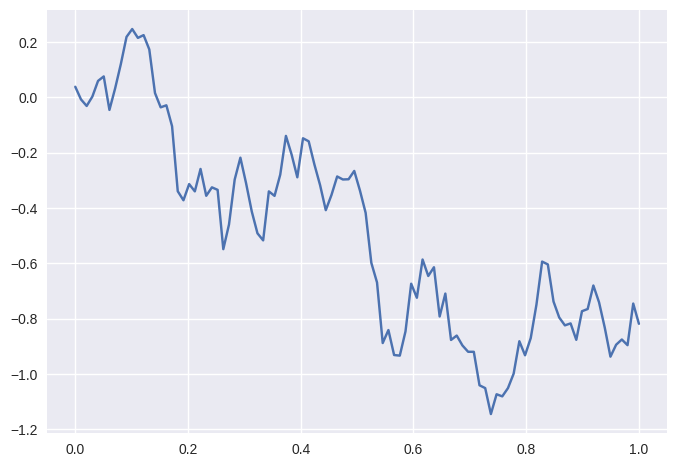

In [10]:
plt.plot(time, bm[0])

In [11]:
l = 0.01
K = gaussian_kernel(time[:, None], time[:, None], l)

I = np.eye(K.shape[0])
nugget = 1e-10
c = scipy.linalg.solve(K + nugget*I, bm.T)

In [12]:
K.shape

(100, 100)

In [13]:
bm_interp = K@c
bm_interp = bm_interp.T

In [14]:
bm_interp.shape, bm.shape

((101, 100), (101, 100))

In [15]:
time.shape, bm.shape

((100,), (101, 100))

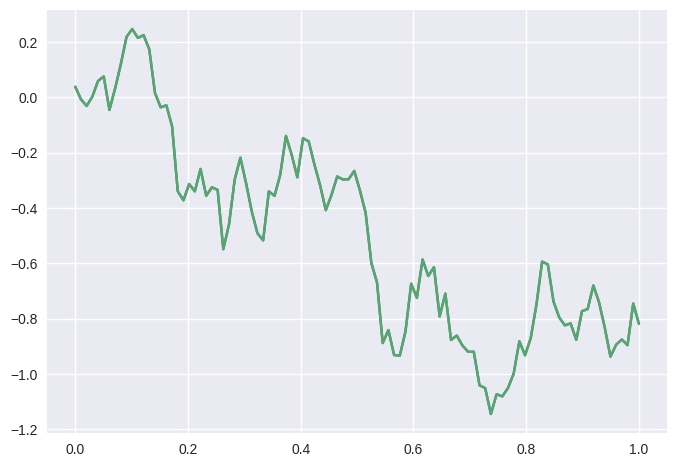

In [16]:
plt.plot(time, bm_interp[0])
plt.plot(time, bm[0])

In [17]:
np.linalg.norm(bm_interp-bm)/np.linalg.norm(bm)

7.060206340015382e-11

# Kernel interpolation
We wish to compute 

$$ \int X_sdX_s = \sum_i \sum_j c_i c_j \int_0^T K(t, t_i)dK(t, t_j) = c^\intercal M c$$

where 
$$ M_{i,j} = \int_0^T K(t, t_i)dK(t, t_j)$$

For simplicity

$$ K(t,t_i) = \exp\Big(-\frac{(t-t_i)^2}{2l^2}\Big)$$
and therefore 
$$ dK(t, t_i) = -\frac{(t-t_i)}{l^2}\exp\Big(-\frac{(t-t_i)^2}{2l^2}\Big) dt$$

For the Brownian motion kernel, we have 

$$ K(t,t_i) = min\{t, t_i\}$$
and  
\begin{align}
dK(t, t_i) = 
\begin{cases}
dt, &\text{when} \; t \leq t_i \\
0 , &\text{otherwise}.
\end{cases}
\end{align}

Therefore 

$$ M_{i,j} = \int_0^{t_j} min\{t, t_i\}dt$$
which can be further simplfied 

\begin{align*}
&t_i > t_j, \int_0^{t_j} min\{t, t_i\}dt =  \int_0^{t_j} t dt =  \frac{t_j^2}{2} \\
&t_i \leq  t_j, \int_0^{t_j} min\{t, t_i\}dt =  \int_0^{t_i} t dt  + \int^{t_j}_{t_i} t_i dt =  \frac{t_i^2}{2} + t_i(t_j - t_i).
\end{align*}

In [18]:
from scipy.integrate import quad

from scipy.spatial.distance import pdist

In [19]:
# Generate brownian motion
def generate_bm(delta_t, T, n_samples, seed = 0 ):
    N = int(T/delta_t)
    bm = []
    x = 0
    time = np.arange(0, T, delta_t)
    
    np.random.seed(seed)
    rv = np.random.normal(size = (n_samples, time.shape[0]))

    rv.shape

    bm = np.cumsum(rv*np.sqrt(delta_t), axis = -1)
    
    return bm

delta_t = 0.01
T = 1.0
n_samples = 1000
N = int(T/delta_t)
time = np.arange(0, T, delta_t)
bm = generate_bm(delta_t, T, n_samples)

In [20]:
bm.shape

(1000, 100)

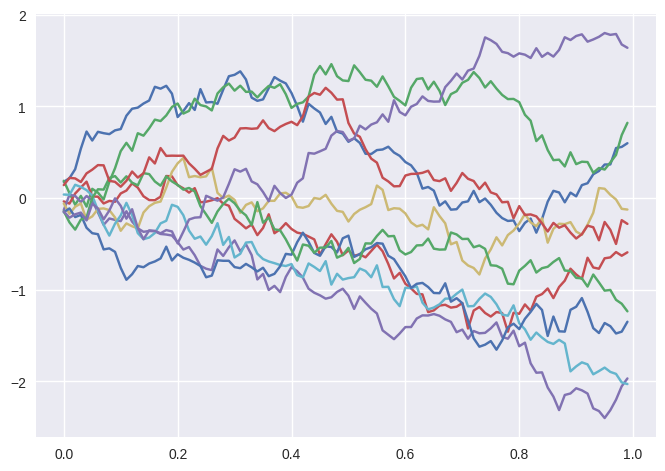

In [21]:
plt.figure()
for i in range(10):
    plt.plot(time, bm[i])

In [22]:
def brownian_motion_kernel(t, T, dt, dt_train):
    st = np.mgrid[t:T:dt, t:T:dt_train]
    
    return st.min(axis=0)

In [23]:
# Compute the M matrix
def compute_M_matrix(N, l):
    M = np.zeros(shape = (N, N))

    for i in range(N):
        for j in range(N):
            t_i = time[i]
            t_j = time[j]
            integrand = lambda t: -(t-t_j)/(l**2)*np.exp(-((t-t_i)**2 + (t-t_j)**2)/(2*l**2))
            M[i,j] = quad(integrand, 0, T)[0]
            
    return M

def compute_interpolant(t0, t1, dt, Y, nugget = 1e-5):
    K = brownian_motion_kernel(t0, t1, dt, dt)
    I = np.eye(K.shape[0])
    nugget = nugget
    #print(Y.shape, K.shape)
    c = scipy.linalg.solve(K + nugget*I, Y.T, assume_a='pos')
    
    return K, c.T



In [24]:
N = time.shape[0]
M = compute_M_matrix(N, l)
K, c = compute_interpolant(t0, T, delta_t, bm, nugget = 1e-8)
bm_interp = np.squeeze(K@c[:, :, None], axis = -1)

NameError: name 't0' is not defined

In [ ]:
M = compute_M_matrix(N, l)

In [ ]:
time.shape, M.shape, K.shape, bm.shape

In [ ]:
# Compute the interpolation error|
np.mean(np.linalg.norm(bm_interp - bm, axis = -1)/np.linalg.norm(bm, axis = -1))

In [ ]:
integral = np.sum(c*np.squeeze(M@c[:, :, None], axis = -1), axis = -1)

print(np.mean(np.linalg.norm(integral - bm[:, -1]**2/2)/np.linalg.norm(bm[:, -1]**2/2)))

In [28]:
delta_list = np.linspace(0.005, 0.1, 10)[::-1]

interpolation_error = []
integral_error = []
integral_error_ito = []

kernel_integral = []

l = 0.001
for i in tqdm(range(len(delta_list))):
    delta_t = delta_list[i]
    T = 1.0
    n_samples = 1000
    N = int(T/delta_t)
    
    # Generate the BM
    bm = generate_bm(delta_t, T, n_samples)
    time = np.linspace(0, T, N)
    
    # Compute the M matrix
    M = compute_M_matrix(N,l )
    
    # Compute the interpolant
    #print(time.shape, bm.shape)
    K, c = compute_interpolant(l, time, bm)
    bm_interp = np.squeeze(K@c[:, :, None], axis = -1)

    
    # Compute the interpolation error
    i_error = np.mean(np.linalg.norm(bm_interp - bm, axis = -1)**2/np.linalg.norm(bm, axis = -1)**2)
    interpolation_error.append(i_error)
    
    # Compute the integral
    integral = np.sum(c*np.squeeze(M@c[:, :, None], axis = -1), axis = -1)
    
    kernel_integral.append(integral)
    
    # Compute the integral error 
    int_error = np.mean(np.linalg.norm(integral - bm[:, -1]**2/2)/np.linalg.norm(bm[:, -1]**2/2))
    integral_error.append(int_error)
    
    # Compute the integral error with ito
    int_ito = np.mean(np.linalg.norm(integral - bm[:, -1]**2/2 - 0.5*T)/np.linalg.norm(bm[:, -1]**2/2 - 0.5*T))
    integral_error_ito.append(int_ito)
    
kernel_integral = np.array(kernel_integral)

  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: compute_interpolant() missing 1 required positional argument: 'Y'

In [29]:
np.min(integral_error)

ValueError: zero-size array to reduction operation minimum which has no identity

In [30]:
delta_list

array([0.1       , 0.08944444, 0.07888889, 0.06833333, 0.05777778,
       0.04722222, 0.03666667, 0.02611111, 0.01555556, 0.005     ])

In [25]:
plt.figure()
plt.plot(delta_list, integral_error, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2$')
plt.plot(delta_list, integral_error_ito, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2 - \frac{1}{2}T$')
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.yscale('log')
plt.xlabel(r'$\Delta t$', size = 20)
plt.ylabel("Relative error", size= 10)
plt.title(r"Relative error", size = 20)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

NameError: name 'delta_list' is not defined

<Figure size 800x550 with 0 Axes>

In [26]:
plt.figure()
plt.plot(delta_list, integral_error, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2$')
plt.plot(delta_list, integral_error_ito, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2 - \frac{1}{2}T$')
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.gca().invert_xaxis()
plt.xlabel(r'$\Delta t$', size = 20)
plt.ylabel("Relative error", size= 10)
plt.title(r"Relative error", size = 20)
plt.legend()
plt.show()

NameError: name 'delta_list' is not defined

<Figure size 800x550 with 0 Axes>

In [27]:
plt.figure()
plt.plot(delta_list, np.mean(kernel_integral, axis  = -1), marker='o', label = "Integral value")
plt.title("Kernel integral emprical mean", size = 20)
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.xlabel(r'$\Delta t$', size = 20)
plt.gca().invert_xaxis()
#plt.yscale('log')
plt.legend()
plt.show()

NameError: name 'delta_list' is not defined

<Figure size 800x550 with 0 Axes>

# Computing the interpolation error using Browninan motion kernel (piecewise linear)

In [160]:
from scipy.integrate import quad
from scipy.spatial.distance import pdist

In [161]:
delta_t = 0.01
t0 = 0
T = 1.0
n_samples = 1000
N = int(T/delta_t)
time = np.linspace(0, T, N)
bm = generate_bm(delta_t, T, n_samples)

In [162]:
time.shape, bm.shape

((100,), (1000, 100))

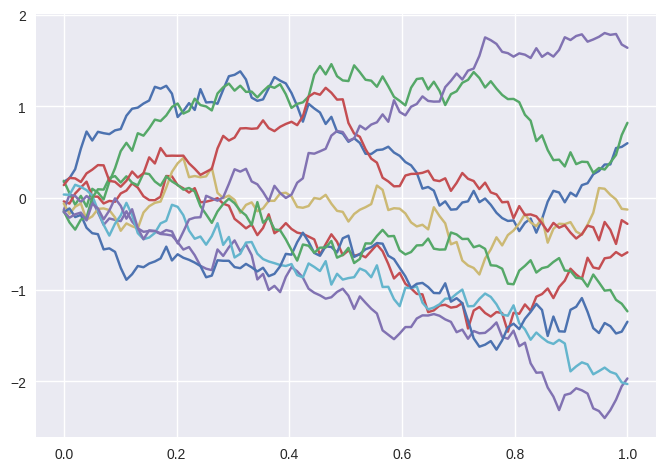

In [163]:
plt.figure()
for i in range(10):
    plt.plot(time, bm[i])

In [164]:
# Compute the M matrix
def compute_M_matrix(N, l):
    M = np.zeros(shape = (N, N))

    for i in range(N):
        for j in range(N):
            t_i = time[i]
            t_j = time[j]
            
            if i > j:
                M[i,j] = t_j**2/2
            elif i <= j:
                M[i,j] = t_i**2/2 + t_i*(t_j - t_i)
            
    return M

def compute_interpolant(t0, t1, dt, Y, nugget = 1e-5):
    K = brownian_motion_kernel(t0, t1, dt, dt)
    I = np.eye(K.shape[0])
    print(K.shape, Y.shape)
    nugget = nugget
    #print(Y.shape, K.shape)
    c = scipy.linalg.solve(K + nugget*I, Y.T, assume_a='pos')
    
    return K, c.T

In [165]:
delta_t

0.01

In [166]:
brownian_motion_kernel(0, 1, delta_t, delta_t).shape

(100, 100)

In [167]:
time.shape, bm.shape

((100,), (1000, 100))

In [168]:
N = time.shape[0]
M = compute_M_matrix(N, l)
K, c = compute_interpolant(t0, T, delta_t, bm, nugget = 1e-8)
bm_interp = np.squeeze(K@c[:, :, None], axis = -1)

(100, 100) (1000, 100)


In [169]:
T

1.0

In [170]:
time.shape

(100,)

In [171]:
bm_interp.shape, bm.shape

((1000, 100), (1000, 100))

In [172]:
# Compute the interpolation error
np.mean(np.linalg.norm(bm_interp - bm, axis = -1)/np.linalg.norm(bm, axis = -1))

0.01577861418696569

In [173]:
integral = np.sum(c*np.squeeze(M@c[:, :, None], axis = -1), axis = -1)

print(np.mean(np.linalg.norm(integral - bm[:, -1]**2/2)/np.linalg.norm(bm[:, -1]**2/2)))

0.020304034118315877


In [174]:
delta_list

array([0.1       , 0.08944444, 0.07888889, 0.06833333, 0.05777778,
       0.04722222, 0.03666667, 0.02611111, 0.01555556, 0.005     ])

In [176]:
bm.shape

(1000, 100)

In [177]:
K, c = compute_interpolant(t0, T, delta_t, bm, nugget = 1e-8)

(100, 100) (1000, 100)


In [181]:
delta_list = np.linspace(0.005, 0.1, 10)[::-1]

interpolation_error = []
integral_error = []
integral_error_ito = []

kernel_integral = []


nugget = 1e-10
for i in tqdm(range(len(delta_list))):
    delta_t = delta_list[i]
    T = 1.0
    n_samples = 1000
    N = int(T/delta_t)
    
    # Generate the BM
    bm = generate_bm(delta_t, T, n_samples)
    time = np.linspace(0, T, N)
    N = time.shape[0]
    print(N)
    
    # Compute the M matrix
    M = compute_M_matrix(N,l )
    
    # Compute the interpolant
    #print(delta_t, t, T)
    K, c = compute_interpolant(t0, T, delta_t, bm, nugget = 1e-10)
    bm_interp = np.squeeze(K@c[:, :, None], axis = -1)

    
    # Compute the interpolation error
    i_error = np.mean(np.linalg.norm(bm_interp - bm, axis = -1)/np.linalg.norm(bm, axis = -1))
    interpolation_error.append(i_error)
    
    # Compute the integral
    integral = np.sum(c*np.squeeze(M@c[:, :, None], axis = -1), axis = -1)
    
    kernel_integral.append(integral)
    
    # Compute the integral error 
    int_error = np.mean(np.linalg.norm(integral - bm[:, -1]**2/2)/np.linalg.norm(bm[:, -1]**2/2))
    integral_error.append(int_error)
    
    # Compute the integral error with ito
    int_ito = np.mean(np.linalg.norm(integral - bm[:, -1]**2/2 - 0.5*T)/np.linalg.norm(bm[:, -1]**2/2 - 0.5*T))
    integral_error_ito.append(int_ito)
    
kernel_integral = np.array(kernel_integral)

 10%|█         | 1/10 [00:00<00:00, 170.47it/s]

10
(10, 10) (1000, 10)
11
(12, 12) (1000, 11)


ValueError: Input b has to have same number of rows as input a

In [65]:
bm.shape

(1000, 200)

In [66]:
np.min(integral_error)

3.946685044470705e-10

In [67]:
delta_list

array([0.1       , 0.08944444, 0.07888889, 0.06833333, 0.05777778,
       0.04722222, 0.03666667, 0.02611111, 0.01555556, 0.005     ])

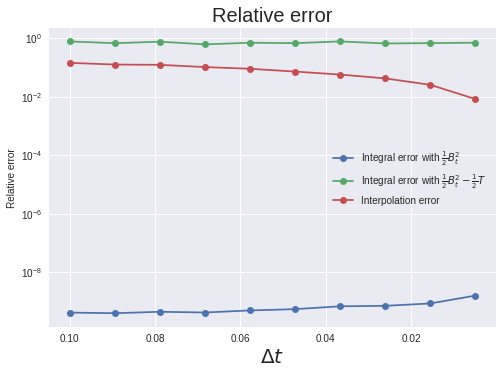

In [68]:
plt.figure()
plt.plot(delta_list, integral_error, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2$')
plt.plot(delta_list, integral_error_ito, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2 - \frac{1}{2}T$')
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.yscale('log')
plt.xlabel(r'$\Delta t$', size = 20)
plt.ylabel("Relative error", size= 10)
plt.title(r"Relative error", size = 20)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

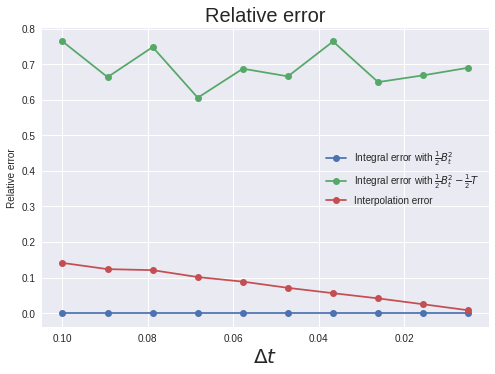

In [69]:
plt.figure()
plt.plot(delta_list, integral_error, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2$')
plt.plot(delta_list, integral_error_ito, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2 - \frac{1}{2}T$')
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.gca().invert_xaxis()
plt.xlabel(r'$\Delta t$', size = 20)
plt.ylabel("Relative error", size= 10)
plt.title(r"Relative error", size = 20)
plt.legend()
plt.show()

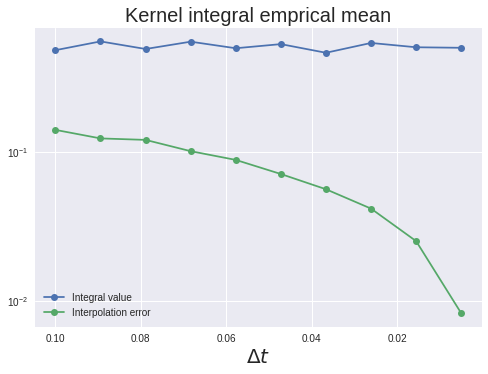

In [74]:
plt.figure()
plt.plot(delta_list, np.mean(kernel_integral, axis  = -1), marker='o', label = "Integral value")
plt.title("Kernel integral emprical mean", size = 20)
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.xlabel(r'$\Delta t$', size = 20)
plt.gca().invert_xaxis()
plt.yscale('log')
plt.legend()
plt.show()